In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/test2classes.zip" "test2classes.zip"
!cp "/content/drive/My Drive/Histopathology data/ResNext2categoriesmodel.pth" "ResNext2categoriesmodel.pth"

In [ ]:
!unzip -q test2classes.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['NORM' 'TUM']
7200
7200


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # 
batch_size_test = 5 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets

test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: NORM


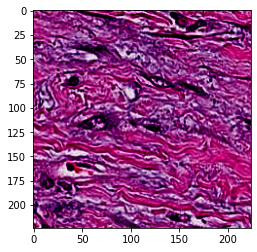

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import torch.nn as nn
import torch.nn.functional as F


class InitBlock(nn.Module):
    expansion = 2  
    
  
    def __init__(self, in_planes, cardinality=32, bottleneck_width=4, stride=1):
        super(InitBlock, self).__init__()
        group_width = cardinality * bottleneck_width
        self.convolution1 = nn.Conv2d(in_planes, group_width, kernel_size=1, bias=False)
        self.batchnormal1 = nn.BatchNorm2d(group_width)
        
        self.convolution2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.batchnormal2 = nn.BatchNorm2d(group_width)
        self.convolution3 = nn.Conv2d(group_width, self.expansion*group_width, kernel_size=1, bias=False)
        self.batchnormal3 = nn.BatchNorm2d(self.expansion*group_width)

        self.shortblock = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*group_width:
            self.shortblock = nn.Sequential(
              nn.Conv2d(in_planes, self.expansion*group_width, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(self.expansion*group_width)
          )

    def forward(self, x):
        y = F.relu(self.batchnormal1(self.convolution1(x)))
        y = F.relu(self.batchnormal2(self.convolution2(y)))
        y = self.batchnormal3(self.convolution3(y))
        y += self.shortblock(x)
        y = F.relu(y)
        return y


class ResNeXt(nn.Module):
    def __init__(self, input_channel, num_blocks, cardinality, bottleneck_width, n_classes):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.planes = 64

        self.convolution1 = nn.Conv2d(input_channel, 64, kernel_size=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.l1 = self.create_layer(num_blocks[0], 1)
        self.l2 = self.create_layer(num_blocks[1], 2)
        self.l3 = self.create_layer(num_blocks[2], 2)
       
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(cardinality*bottleneck_width*8, n_classes)

    def create_layer(self, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(InitBlock(self.planes, self.cardinality, self.bottleneck_width, stride))
            self.planes = InitBlock.expansion * self.cardinality * self.bottleneck_width
        
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        y = F.relu(self.batchnorm1(self.convolution1(x)))
        y = self.l1(y)
        y = self.l2(y)
        y = self.l3(y)
        
        y = self.pool(y)
        y = y.view(y.size(0), -1)
        y = self.linear(y)
        return y



def ResNeXt29_2x64d(input_channel, n_classes):
    return ResNeXt(input_channel=input_channel, num_blocks=[3,3,3], cardinality=2, bottleneck_width=64, n_classes=n_classes)


In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNeXt29_2x64d(input_channel=3, n_classes=2)
model.load_state_dict(torch.load('ResNext2categoriesmodel.pth', map_location=device))
model=model.to(device)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
   
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    y=[]
    y_pred=[]
    prob=[]
    for data, target in test_loader:
        t=target.tolist()
        y.append(t)
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        p=output.tolist()
        prob.append(p)     
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        m=pred.tolist()
        y_pred.append(m) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg, y,y_pred,prob

In [ ]:
import os.path
from os import path



stl,acct,y,y_pred,prob=test(model, device, test_loader)

print('average accuracy: ',acct)

Test: Average loss: 0.1115, Accuracy: 6930/7200 (96.25%)

average accuracy:  96.25


In [ ]:
flat_prob=[element for sublist in prob for element in sublist]
proba=np.array(flat_prob)
flatten_y = [element for sublist in y for element in sublist]
flatten_y_pred = [element for sublist in y_pred for element in sublist]
flatten_y_pred = [element for sublist in flatten_y_pred for element in sublist]

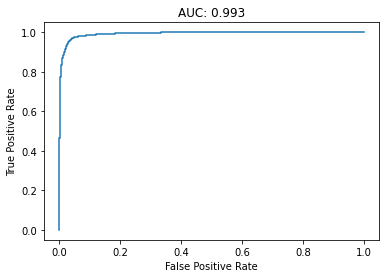

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred_proba = proba[::,1]
fpr, tpr, thresholds = roc_curve(flatten_y, y_pred_proba)
auc = roc_auc_score(flatten_y, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('AUC: %.3f' % auc)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision=precision_score(flatten_y, flatten_y_pred)
precision=precision*100
print(precision)

96.1218836565097


In [ ]:
recall=recall_score(flatten_y, flatten_y_pred)
recall=recall*100
print(recall)

96.38888888888889


In [ ]:
f1=f1_score(flatten_y, flatten_y_pred)
f1=f1*100
print(f1)

96.25520110957004
